# Settings

In [ ]:
!pip install wordcloud konlpy
!apt-get -qq install -y fonts-nanum
!pip install --upgrade -q accelerate bitsandbytes
!pip install git+https://github.com/huggingface/transformers.git
!pip install sentence_transformers
!fc-cache -fv
!pip install selenium
!pip install webdriver-manager

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-zcwfwako
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-zcwfwako
  Resolved https://github.com/huggingface/transformers.git to commit 33eef992503689ba1af98090e26d3e98865b2a9b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such

In [ ]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
import itertools, csv, json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.font_manager as fm
import ast, re, os
from time import sleep
import random, requests, time, shutil
from tqdm import tqdm
import urllib.parse
import torch
import torch.nn.functional as f
from PIL import Image, ImageOps
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModel, AutoProcessor, AutoTokenizer, BertTokenizer, LlavaForConditionalGeneration, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer
from konlpy.tag import Okt
from wordcloud import WordCloud
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import ElementNotInteractableException
from selenium.common.exceptions import StaleElementReferenceException
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

# 1. Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## LLAVA

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

# LLAVA 사전 학습 모델 로드
model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)
model1 = LlavaForConditionalGeneration.from_pretrained(model_id, quantization_config=quantization_config, device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

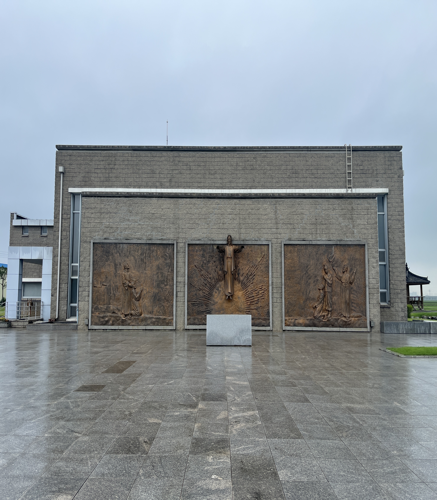

In [ ]:
# 경로 설정
directory = '/content/drive/MyDrive/test_data'

# 디렉토리 안의 파일 목록 가져오기
all_files = os.listdir(directory)

# 이미지 파일만 필터링 (예: jpg, png, jpeg 형식)
image_files = [file for file in all_files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

seed_value = 200
random.seed(seed_value)

# 랜덤으로 이미지 파일 선택
random_images = random.sample(image_files, 1)

image_paths = [f'{directory}/{image}' for image in random_images]

test_image = []
for image_path in image_paths:
    # 이미지 열기
    image = Image.open(image_path)
    image = ImageOps.exif_transpose(image)  # EXIF 정보를 이용해 올바른 방향으로 회전
    test_image.append(image)
    # 이미지 크기 조정 후 표시
    display(image.resize((437, 500)))

In [ ]:
# 프롬프트 정의
prompts = [
    "USER: <image>\n What other travel destinations or travel activities do you have that go well with this place? Please list it in words. \nASSISTANT:",
    "USER: <image>\n Please express the season that goes best with this picture and why. \nASSISTANT:",
    "USER: <image>\n Tell me about the mood, touch and feelings of this image in detail. Use as many adjectives as possible to express them. Reduce objective descriptions and add a lot of subjective expressions. \nASSISTANT:",
    "USER: <image>\n Describe this image objectively and realistically using the objects in this image. Do not include subjective words such as the mood, touch, atmosphere and feelings. \nASSISTANT:"
]

responses = {}
for image in test_image:

    # 각 프롬프트에 대해 답변 생성
    response_4 = []
    for prompt in prompts:
        inputs = processor([image], [prompt], padding=True, return_tensors="pt").to("cuda")
        output = model1.generate(**inputs, max_new_tokens=100)
        generated_text = processor.batch_decode(output, skip_special_tokens=True)

        # "ASSISTANT:" 이후의 텍스트만 추출하여 저장
        if "ASSISTANT:" in generated_text[0]:
            response = generated_text[0].split("ASSISTANT:")[-1].strip()
        else:
            response = generated_text[0].strip()
        response_4.append(response)

    responses[f'{image}'] = response_4

# 딕셔너리를 데이터프레임으로 변환
df_test = pd.DataFrame.from_dict(responses, orient='index')
df_test['image'] = random_images
df_test.columns = ['response_1', 'response_2', 'response_3', 'response_4', 'image']

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


## BERT

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 문장 임베딩을 위한 BERT 모델 로드
MODEL_NAME = 'bert-base-nli-mean-tokens'
model2 = SentenceTransformer(MODEL_NAME)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# 2. Data

## 데이터 전처리 및 구축

In [ ]:
# image unzip
!unzip -q "/content/drive/MyDrive/148.국내 여행로그 데이터_제주도 및 도서지역_2차년도/3.개방데이터/1.데이터/Training/01.원천데이터/TS_photo.zip" -d "/content/drive/MyDrive/test_data"

### recommend / spot / consume table

In [ ]:
path = '/content/drive/MyDrive/148.국내 여행로그 데이터_제주도 및 도서지역_2차년도/3.개방데이터/1.데이터/Training/TL_CSV'


photo = pd.read_csv(path+'/tn_tour_photo_관광사진_H.csv')
visit = pd.read_csv(path+'/tn_visit_area_info_방문지정보_H.csv')
traveler = pd.read_csv(path+'/tn_traveller_master_여행객 Master_H.csv')
act_consume = pd.read_csv(path+'/tn_activity_consume_his_활동소비내역_H.csv')

1. visit(방문지 정보 데이터)

In [ ]:
# 결측치 제거
visit = visit.dropna(subset = ['X_COORD','Y_COORD','DGSTFN', 'REVISIT_INTENTION', 'RCMDTN_INTENTION'])
# 관광지 유형의 장소만 추출
visit_filtered = visit[(visit['VISIT_AREA_TYPE_CD'].isin([1, 2, 3, 4, 5, 6, 7, 13]))]

# 평점 계산(만족도, 재방문 의향, 추천 의향 평균)
visit_filtered['ratings'] = visit_filtered[['DGSTFN', 'REVISIT_INTENTION', 'RCMDTN_INTENTION']].mean(axis=1)

# TRAVELER_ID 추출
visit_filtered['TRAVELER_ID'] = visit_filtered['TRAVEL_ID'].str.split('_').str[1]

# 제주도 지역만 추출
visit_jeju = visit_filtered[((visit['ROAD_NM_ADDR'].str.startswith('제주'))) | (visit['LOTNO_ADDR'].str.startswith('제주'))]
visit_jeju = visit_jeju.reset_index(drop = True)

visit_jeju = visit_jeju[['VISIT_AREA_ID', 'TRAVEL_ID', 'TRAVELER_ID', 'VISIT_AREA_NM', 'ROAD_NM_ADDR', 'POI_ID','POI_NM','X_COORD', 'Y_COORD','ratings']]

2. traveler(여행자 정보 데이터)

In [ ]:
columns = ['TRAVELER_ID','GENDER', 'AGE_GRP','TRAVEL_STYL_1','TRAVEL_MOTIVE_1']
traveler = traveler[columns]

# LabelEncoder를 사용하여 GENDER를 숫자로 변환
encoder = LabelEncoder()
traveler['GENDER'] = encoder.fit_transform(traveler['GENDER'])

3. photo(사진 정보 데이터)

In [ ]:
# 필요한 정보만 추출
photo = photo[['TRAVEL_ID', 'VISIT_AREA_ID', 'PHOTO_FILE_NM']]

# 사진의 고유 ID 생성
photo['combined_id'] = photo['TRAVEL_ID'].astype(str) + '_' + photo['VISIT_AREA_ID'].astype(str)

In [ ]:
# photo와 visit_filtered 병합
filtered_photo = photo.merge(
    visit_filtered[['VISIT_AREA_ID', 'TRAVEL_ID']],
    on=['VISIT_AREA_ID', 'TRAVEL_ID'],
    how='inner'
)
# 중복 제거
filtered_photo_new=filtered_photo.drop_duplicates(subset='TRAVEL_ID')
filtered_photo_new=filtered_photo_new.reset_index()
filtered_photo_new.to_csv('/content/drive/MyDrive/filtered_photo.csv', index=False)

4. act_consume(소비 내역 데이터)

In [ ]:
# 해당 장소에 대해 평균 지출 계산
aggregated_df = act_consume.groupby('ROAD_NM_ADDR', as_index=False)['PAYMENT_AMT_WON'].mean()

5. 데이터 병합

In [ ]:
# visit - photo
# 사진이 없더라도 정보가 보존되어야 하기때문에 left join
visit_jeju_final = pd.merge(visit_jeju, photo, on=['VISIT_AREA_ID', 'TRAVEL_ID'], how='left')

In [ ]:
# visit_jeju_final - traveler
recommend_table = pd.merge(visit_jeju_final, traveler, on='TRAVELER_ID', how='inner')

In [ ]:
# 결측 사진 처리
recommend_table['PHOTO_FILE_NM'] = recommend_table['PHOTO_FILE_NM'].fillna('')

# 같은 장소에 대해 여러 사진이 있는 경우 처리(제거)
recommend_table = recommend_table.drop_duplicates(subset=['VISIT_AREA_ID', 'TRAVELER_ID'])\
    .reset_index(drop=True)
recommend_table.head()

In [ ]:
# 중복되는 장소 중에, 사진 파일이 있는 데이터를 우선적으로 남기고 중복 제거
spot_table = recommend_table.sort_values(by='PHOTO_FILE_NM', ascending=False) \
                            .drop_duplicates(subset=['POI_ID']) \
                            .reset_index(drop=True)
spot_table.head()

In [ ]:
# recommend - consume
recommend_with_consume = recommend_table.merge(aggregated_df, on='ROAD_NM_ADDR', how='left')
recommend_with_consume['PAYMENT_AMT_WON'] = recommend_with_consume['PAYMENT_AMT_WON'].fillna(0) # 소비량 결측값 0원으로 대체

In [ ]:
recommend_with_consume.to_csv(path+"/recommend_with_consume_wt_rv.csv", index = False)
spot_table.to_csv(path+"/spot_table_wt_rv.csv", index = False)

### kakao map review clawling data

웹 크롤링(로컬에서만 실행)

In [ ]:
''' Chrome 옵션 설정 '''
options = Options()

# 브라우저 창을 띄우지 않고 백그라운드에서 실행. 디버깅을 위해 창을 띄우도록 하자.
#options.add_argument('--headless')
# 사용자 에이전트 설정
options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Whale/3.28.266.14 Safari/537.36')
# 창을 최대화하여 열기
options.add_argument("--start-maximized")
# GPU 가속 사용 안함
options.add_argument('--disable-gpu')
# /dev/shm 사용 안함
options.add_argument('--disable-dev-shm-usage')

# Chrome 드라이버 초기화
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

In [ ]:
''' 전체 과정 함수 '''
def main(start, end):
    global driver

    # 페이지가 로드될 때까지 최대 4초 기다린다
    driver.implicitly_wait(4)
    # 카카오맵 사이트 로드
    driver.get('https://map.kakao.com/')

    result_df = pd.read_excel("result_df_1111.xlsx")
    result_df = result_df.iloc[start:end]

    # 각 장소에 대해 반복
    for i, (place, index) in enumerate(zip(result_df['search_place_name'], result_df.index)):
        # delay
        if i % 4 == 0 and i != 0:
            sleep(5)
        print(f"## {place}을(를) 크롤링합니다. ({i+1}/{len(result_df)})")
        search(place, index, result_df)

    # 모든 검색이 완료되면 webdriver 종료하여 브라우저를 닫는다.
    driver.quit()
    print("크롤링이 모두 완료되었습니다.")

    result_df.to_excel(f"result_df_{start}.xlsx", index=False)
    return result_df


def search(place, index, result_df):
    global driver

    # 검색 창의 HTML 요소를 XPath로 찾아 저장
    search_area = driver.find_element(By.XPATH, '//*[@id="search.keyword.query"]')
    search_area.send_keys(place)
    # Enter키를 누르도록 하여 검색을 실행
    driver.find_element(By.XPATH, '//*[@id="search.keyword.submit"]').send_keys(Keys.ENTER)
    # 1초 동안 페이지 로드 대기
    sleep(1)

    # 현재 페이지의 HTML 소스 가져온다
    html = driver.page_source
    # HTML 소스를 파싱
    soup = BeautifulSoup(html, 'html.parser')

    # 검색 결과에 나온 첫 페이지의 장소 목록을 추출
    place_lists = soup.select('.placelist > .PlaceItem')

    # 첫 번째 검색 결과만 크롤링
    if place_lists:
        # 첫 번째 장소만 선택
        first_place = place_lists[0]
        first_place_address = first_place.select('.info_item > .addr > p')[0].text
        # 상세페이지 XPath 동적 생성을 위한 인덱스
        li_index = 1

        # 주소에 '제주'가 포함되지 않으면 두 번째 장소로 대체
        if '제주' not in first_place_address and len(place_lists) > 1:
            first_place = place_lists[1]
            print(f"첫 번째 장소의 주소에 '제주'가 포함되지 않아 두 번째 장소인 '{first_place}'로 대체합니다.")
            li_index = 2

        # 최종 선택된 장소를 크롤링
        crawling(first_place, index, li_index, result_df)

    # 검색 창의 내용을 지워 다음 검색에 대비
    search_area.clear()


''' 리뷰 크롤링 '''
def crawling(place, index, li_index, result_df):
    global driver

    # 장소 이름과 주소 가져오기
    place_name = place.select('.head_item > .tit_name > .link_name')[0].text
    place_address = place.select('.info_item > .addr > p')[0].text

    # 크롤링한 장소 이름과 주소를 result_df에 저장
    result_df.loc[index, 'place_name'] = place_name
    result_df.loc[index, 'place_address'] = place_address

    # 장소의 상세 페이지로 이동하기 위한 XPath 생성
    detail_page_xpath = f'//*[@id="info.search.place.list"]/li[{li_index}]/div[5]/div[4]/a[1]'
    # 장소의 상세 페이지로 이동하기 위해 '상세보기' 클릭
    driver.find_element(By.XPATH, detail_page_xpath).send_keys(Keys.ENTER)
    # 새로 열린 상세 페이지 탭으로 전환
    driver.switch_to.window(driver.window_handles[-1])
    sleep(1)

    print(f"{place_name} 상세 페이지로 이동했습니다.")

    # 모든 리뷰를 추출
    extract_review(place_name, index, result_df)

    # 현재 상세 페이지를 닫는다.
    driver.close()
    # 검색 탭으로 전환
    driver.switch_to.window(driver.window_handles[0])


def extract_review(place_name, index, result_df):
    global driver

    # 가장 마지막으로 확인된 nth-child 번호
    last_review_index = 1
    # 해당 장소에 대한 누적 리뷰 개수를 추적
    review_count = 0
    # 이전 반복의 누적 리뷰 개수
    previous_review_count = None
    # 새 리뷰가 있는지 확인하기 위한 플래그
    new_reviews_found = True

    while new_reviews_found and review_count < 100:

        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')

        # 현재 페이지의 모든 리뷰 목록 가져오기
        review_lists = soup.select('#mArticle > div.cont_evaluation > div.evaluation_review > ul > li')
        #print(len(review_lists))

        # 리뷰 개수에 변화가 없으면 크롤링 종료
        if review_count == previous_review_count:
            print("리뷰 수에 변화가 없으므로 크롤링을 종료합니다.")
            break
        previous_review_count = review_count  # 이전 리뷰 개수를 업데이트

        new_reviews_found = True  # 새 리뷰가 있는지 확인하기 위한 플래그

        # 현재 페이지의 리뷰 목록 중, last_review_index 이후의 리뷰만 크롤링
        for i in range(last_review_index, len(review_lists) + 1):
            # `nth-child(i)`을 이용해 리뷰 요소에 접근
            comment_css_selector = f'#mArticle > div.cont_evaluation > div.evaluation_review > ul > li:nth-child({i}) > div.comment_info > p > span'
            comment = soup.select(comment_css_selector)
            comment_text = comment[0].text.strip() if comment else '.'

            if comment_text == ".":
                continue  # 리뷰 텍스트가 없을 경우 건너뜀

            # 별점 추출
            rating_css_selector = f'#mArticle > div.cont_evaluation > div.evaluation_review > ul > li:nth-child({i}) .ico_star.inner_star'
            rating_span = soup.select_one(rating_css_selector)
            rating = 0  # 기본값
            if rating_span and 'style' in rating_span.attrs:
                # style 속성에서 숫자만 추출
                width_value = int(re.search(r'width:(\d+)%', rating_span['style']).group(1))
                # width 값에 따라 별점 계산
                rating = str(width_value // 20)

            # result_df에 리뷰와 별점 추가 (리뷰와 별점 정보가 리스트 형태로 저장됨)
            result_df.at[index, 'comment_text'] = (
                    result_df.at[index, 'comment_text'] + [comment_text]
                    if isinstance(result_df.at[index, 'comment_text'], list)
                    else [comment_text]
                )
            result_df.at[index, 'rating'] = (
                    result_df.at[index, 'rating'] + [rating]
                    if isinstance(result_df.at[index, 'rating'], list)
                    else [rating]
                )

            review_count += 1
            if review_count >= 100:
                print("Collected 100 reviews. Stopping the crawl.")
                break  # Exit the loop if review limit is reached

        if review_count >= 100:
            break  # Break the outer loop as well


        # '후기 더보기' 버튼 클릭 시 추가 리뷰 로드
        try:
            # 가능한 XPath를 순서대로 시도
            more_button = None
            xpaths = [
                '//*[@id="mArticle"]/div[7]/div[2]/a',
                '//*[@id="mArticle"]/div[8]/div[3]/a',
                '//*[@id="mArticle"]/div[7]/div[3]/a',
                '//*[@id="mArticle"]/div[6]/div[3]/a',
                '//*[@id="mArticle"]/div[9]/div[3]/a',
                '//*[@id="mArticle"]/div[6]/div[2]/a',
                '//*[@id="mArticle"]/div[5]/div[2]/a',
                '//*[@id="mArticle"]/div[5]/div[3]/a'
            ]
            for xpath in xpaths:
                try:
                    more_button = driver.find_element(By.XPATH, xpath)
                    # 버튼 텍스트 확인
                    if more_button.text == '후기 접기':
                        print("후기 접기 버튼이 나타났으므로 크롤링을 종료합니다.")
                        new_reviews_found = False
                        break
                    elif more_button.text == '후기 더보기':
                        more_button.send_keys(Keys.ENTER)
                        sleep(1)
                        break  # 버튼을 찾고 클릭했다면 루프 종료
                except (NoSuchElementException, ElementNotInteractableException):
                    continue  # 현재 XPath에서 버튼을 찾지 못한 경우, 다음 XPath 시도
            # 세 가지 XPath 중 어느 것도 찾지 못하거나 후기 접기이면 크롤링 종료
            if more_button is None or more_button.text == '후기 접기 ':
                print("크롤링을 완료하였습니다.")
                new_reviews_found = False
                break
        except (NoSuchElementException, ElementNotInteractableException):
            print("크롤링을 완료하였습니다.")
            new_reviews_found = False
            break

        # last_review_index를 업데이트하여 다음 페이지의 새 리뷰만 크롤링
        last_review_index = len(review_lists) + 1

리뷰 데이터 임베딩

In [ ]:
df=main()
def safe_literal_eval(text):
    # 문장부호를 제외한 특수문자 제거
    text = re.sub(r'[^a-zA-Z0-9ㄱ-ㅎㅏ-ㅣ가-힣\s.,!?;:\'"]', '', text)
    # ㅋㅋ나 ㅠㅠ와 같은 자음이나 모음만으로 구성된 불완전한 텍스트 제거
    text = re.sub(r'(ㅋ+|ㅠ+|ㅜ+|^ㄱ|ㄴ|ㅇ|ㅁ|ㅂ|ㅈ|ㅊ|ㅌ|ㅍ|ㅎ|ㅏ|ㅑ|ㅓ|ㅕ|ㅗ|ㅛ|ㅜ|ㅠ|ㅡ|ㅣ)', '', text)
    try:
        # 역슬래시 제거 후 str -> list
        return ast.literal_eval(text.replace("\\'", "'"))
    except (SyntaxError, ValueError):
        return []

df['comment_text'] = df.comment_text.apply(lambda x: safe_literal_eval(x) if pd.notna(x) else [])
df['comment_text'] = df.comment_text.apply(lambda x: list(x[:100]) if len(x)>100 else list(x))
df['rating'] = df.rating.apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
df['rating'] = df.rating.apply(lambda x: list(map(int, x)))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 주의) 국문 텍스트 이므로 한국어를 다루는 kobert 사용
MODEL_NAME = 'monologg/kobert'
model = SentenceTransformer(MODEL_NAME, trust_remote_code=True)

# 리뷰 텍스트 뭉치를 벡터로 임베딩하는 함수
def reviews_to_vec(reviews):
  if len(reviews) == 0:
    return np.zeros(768)
  else:
    return model.encode(reviews).mean(axis=0)

In [ ]:
tqdm.pandas()
# 리뷰 임베딩
embedding = df.comment_text.progress_apply(reviews_to_vec)
reviews_embedded = pd.DataFrame(embedding.tolist(), columns=[f'embedding_{i}' for i in range(768)])
# 병합
reviews_embedded = pd.concat([df,reviews_embedded],axis=1)

In [ ]:
reviews_embedded = reviews_embedded.rename(columns={'addr_v':'ROAD_NM_ADDR', 'visit_names_v':'VISIT_AREA_NM'})
reviews_embedded.to_csv(path + '/reviews_embeded.csv',index=False)

리뷰 정보 추가

In [ ]:
columns = ['ROAD_NM_ADDR','VISIT_AREA_NM'] + list(reviews_embedded.columns[5:])
recommend_with_consume = pd.merge(recommend_with_consume, reviews_embedded[columns],how='left',on = ['VISIT_AREA_NM','ROAD_NM_ADDR'])
recommend_with_consume = recommend_with_consume[(recommend_with_consume.embedding_0!=0) & (recommend_with_consume.embedding_0.notna())]
spot_table = pd.merge(spot_table,reviews_embedded[columns],how='left',on = ['VISIT_AREA_NM','ROAD_NM_ADDR'])
spot_table = spot_table[spot_table.embedding_0!=0]

In [ ]:
spot_table.to_csv(path+'/spot_table_wt_rv.csv', index=False)
recommend_with_consume.to_csv(path+'/recommend_with_consume_wt_rv.csv', index=False)

### 이미지 데이터

In [ ]:
# 특정 이미지만 옮기기

# 경로 설정
images_path = "/content/drive/MyDrive/test_data"
csv_file_path = "/content/filtered_photo_new.csv"
output_folder = "/content/drive/MyDrive/filtered_images"

# output_folder가 존재하지 않으면 생성
os.makedirs(output_folder, exist_ok=True)

# filtered_photo_new.csv 파일 읽기
df = pd.read_csv(csv_file_path)

# 'PHOTO_FILE_NM' 열에서 파일명 리스트 얻기
photo_file_names = df['PHOTO_FILE_NM'].tolist()

# 이미지 파일 필터링
selected_images = [f for f in os.listdir(images_path) if f in photo_file_names]

# 정렬
selected_images = sorted(selected_images)
images_to_process = selected_images[:100]  # 처음 100개 이미지를 처리 (테스트용)


# 필터링된 이미지들을 하위 폴더로 복사
for image in selected_images:
    source_path = os.path.join(images_path, image)
    destination_path = os.path.join(output_folder, image)
    shutil.move(source_path, destination_path)  # 지정된 파일이 이동하며 원본 폴더에서 삭제됨

print(f"{len(selected_images)} images copied to {output_folder}")

LLaVA model 답변 생성

In [ ]:
# 경로 설정
images_path = "/content/drive/MyDrive/filtered_images"
csv_path = "/content/drive/MyDrive/responses_final.csv"

# 프롬프트 정의
prompts = [
    "USER: <image>\n What other travel destinations or travel activities do you have that go well with this place? Please list it in words. \nASSISTANT:",
    "USER: <image>\n Please express the season that goes best with this picture and why. \nASSISTANT:",
    "USER: <image>\n Tell me about the mood, touch and feelings of this image in detail. Use as many adjectives as possible to express them. Reduce objective descriptions and add a lot of subjective expressions. \nASSISTANT:",
    "USER: <image>\n Describe this image objectively and realistically using the objects in this image. Do not include subjective words such as the mood, touch, atmosphere and feelings. \nASSISTANT:"
]

# 이미지 리스트 불러오기
all_images = [f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
all_images = sorted(all_images)  # 정렬하여 일관성 유지
images_to_process = all_images[1000:]  # 숫자 바꿔가며 진행

# CSV 파일이 비어있거나 없을 경우 생성 및 초기화
if not os.path.exists(csv_path) or os.path.getsize(csv_path) == 0:
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        # 헤더 작성
        writer.writerow(['image'] + [f'response_{i+1}' for i in range(len(prompts))])
    processed_images = set()
else:
    # CSV 파일이 있을 경우 불러오기
    existing_df = pd.read_csv(csv_path)
    processed_images = set(existing_df['image'].tolist())

# 실시간 CSV 저장으로 이미지 처리
with open(csv_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    for image_name in images_to_process:
        if image_name in processed_images:
            continue  # 이미 처리된 이미지는 건너뜀

        # 이미지 경로 및 데이터 로딩
        image_path = os.path.join(images_path, image_name)
        try:
            image = Image.open(image_path)
            # 이미지 리사이즈 (모델에서 요구하는 입력 크기 예: 224x224)
            target_size = (224, 224)
            image_resized = image.resize(target_size)
        except Exception as e:
            print(f"Error processing image {image_name}: {e}")
            continue

        responses = []
        # 각 프롬프트에 대해 답변 생성
        for prompt in prompts:
            inputs = processor([image_resized], [prompt], padding=True, return_tensors="pt").to("cuda")
            output = model.generate(**inputs, max_new_tokens=100)
            generated_text = processor.batch_decode(output, skip_special_tokens=True)

            # "ASSISTANT:" 이후의 텍스트만 추출하여 저장
            if "ASSISTANT:" in generated_text[0]:
                response = generated_text[0].split("ASSISTANT:")[-1].strip()
            else:
                response = generated_text[0].strip()

            responses.append(response)

        # CSV에 이미지 이름과 생성된 답변 저장
        writer.writerow([image_name] + responses)
        print(f"Processed and saved: {image_name}")

print("100개의 이미지 처리가 완료되었습니다. CSV 파일이 업데이트되었습니다.")

임베딩 벡터 저장

In [ ]:
aihub_cap = pd.read_csv('/content/drive/MyDrive/responses_final.csv')

def prepare_aihub_embeddings(aihub_image, categories):
    # 이미지를 리스트로 저장
    images = aihub_image['image'].tolist()
    embeddings_list = []  # 임베딩을 저장할 리스트 초기화

    for category in categories:
        sentences_aihub = aihub_image[category].tolist()
        # 각 category의 임베딩을 NumPy 배열로 변환한 후 리스트에 추가
        category_embeddings = model2.encode(sentences_aihub).tolist()  # tolist()를 사용하여 리스트로 변환

        # 각 이미지와 해당 임베딩을 함께 저장
        for image, embedding in zip(images, category_embeddings):
            embeddings_list.append({
                'image': image,
                'embedding': embedding,  # 임베딩을 리스트 형태로 저장
                'category': category
            })

    return embeddings_list  # 리스트 형태로 반환

# 사용 예시
categories = ['response_1', 'response_2', 'response_3', 'response_4']
aihub_embeddings_list = prepare_aihub_embeddings(aihub_cap, categories)

# 파일에 저장할 경로 설정
output_file = '/content/drive/MyDrive/aihub_embeddings.json'

# aihub_embeddings_list를 JSON 파일로 저장
with open(output_file, 'w') as f:
    json.dump(aihub_embeddings_list, f)

코사인 유사도 저장

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/responses_final3.csv')
# 각 열에 대해 2개씩의 행 간 유사도를 계산하여 저장하는 함수
def calculate_pairwise_cosine_similarity(df, column):
    # 해당 열의 텍스트 데이터를 임베딩
    sentences = df[column].tolist()
    sentence_embeddings = model2.encode(sentences)

    # 쌍(pairwise)의 코사인 유사도를 저장할 리스트
    similarity_list = []

    # 각 행을 두 개씩 비교하면서 유사도를 계산
    for i in range(len(sentences)):
        for j in range(i + 1, len(sentences)):
            # i번째와 j번째 행의 유사도 계산
            cosine_sim = cosine_similarity([sentence_embeddings[i]], [sentence_embeddings[j]])[0][0]
            # 이미지 파일명, i번째 행, j번째 행, 유사도를 저장
            similarity_list.append({
                'image_1': df['image'][i],
                'image_2': df['image'][j],
                'response_column': column,
                'cosine_similarity': cosine_sim
            })

    # 결과를 데이터프레임으로 변환
    return pd.DataFrame(similarity_list)

# 모든 response 열에 대해 코사인 유사도를 계산한 후 결과를 저장
all_similarity_dfs = []

for column in df.columns[1:]:  # 'image' 열을 제외하고 각 response 열에 대해 계산
    similarity_df = calculate_pairwise_cosine_similarity(df, column)
    all_similarity_dfs.append(similarity_df)

# 모든 결과를 하나의 데이터프레임으로 합치기
final_similarity_df = pd.concat(all_similarity_dfs, ignore_index=True)

## 데이터 로드

In [ ]:
output_file = '/content/drive/MyDrive/aihub_embeddings_1112.json'
with open(output_file, 'r') as f:
    loaded_aihub_embeddings_list = json.load(f)

In [ ]:
final_similarity_df=pd.read_csv("/content/drive/MyDrive/final_similarity_df_1112.csv")
spot_table=pd.read_csv(path+"/spot_table_wt_rv.csv") #
recommend_with_consume = pd.read_csv(path+"/recommend_with_consume_wt_rv.csv") #

# 3. Recommendation - 1 (Image)

## Test Images

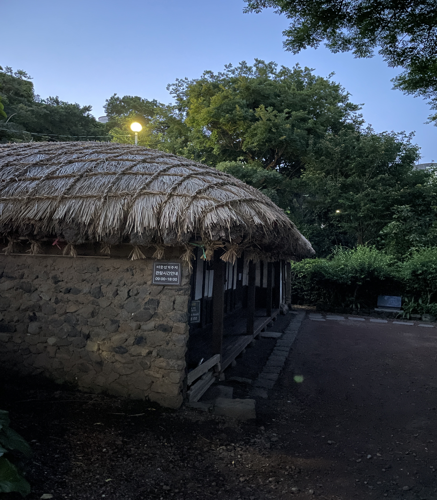

In [ ]:
image_path = '/content/test_image.png'

# 이미지 열기
image = Image.open(image_path)
image = ImageOps.exif_transpose(image)  # EXIF 정보를 이용해 올바른 방향으로 회전

# 리스트에 이미지 추가
test_image = [image]

# 이미지 크기 조정 후 표시
display(image.resize((437, 500)))

## Image Captioning for test images

In [ ]:
responses = {}
for image in test_image:

    # 각 프롬프트에 대해 답변 생성
    response_4 = []
    for prompt in prompts:
        inputs = processor([image], [prompt], padding=True, return_tensors="pt").to("cuda")
        output = model1.generate(**inputs, max_new_tokens=100)
        generated_text = processor.batch_decode(output, skip_special_tokens=True)

        # "ASSISTANT:" 이후의 텍스트만 추출하여 저장
        if "ASSISTANT:" in generated_text[0]:
            response = generated_text[0].split("ASSISTANT:")[-1].strip()
        else:
            response = generated_text[0].strip()
        response_4.append(response)

    responses[f'{image}'] = response_4

# 딕셔너리를 데이터프레임으로 변환
df_test = pd.DataFrame.from_dict(responses, orient='index')
df_test['image'] = test_image
df_test.columns = ['response_1', 'response_2', 'response_3', 'response_4', 'image']

> 이미지 1장당 캡셔닝 시간: 총 23초 소요

## Step 1(카테고리별 텍스트 유사도 기반)

In [ ]:
# df_responses는 df_test의 복사본으로 설정
df_responses = df_test

# 유사도 계산 함수
def calculate_pairwise_cosine_similarity(user_image, aihub_image_embeddings_list, category):
    sentences_user = user_image[category].tolist()
    sentences_user_embedding = model2.encode(sentences_user)  # user 이미지 텍스트 임베딩

    similarity_list = []

    # user 이미지의 각 임베딩과 aihub 임베딩을 비교
    for i in range(len(sentences_user_embedding)):
        for aihub_entry in aihub_image_embeddings_list:
            if aihub_entry['category'] == category:  # 카테고리 체크
                aihub_embedding = aihub_entry['embedding']  # 임베딩을 가져옴
                cosine_sim = cosine_similarity([sentences_user_embedding[i]], [aihub_embedding])[0][0]

                # aihub_entry에서 이미지 정보도 참조
                similarity_list.append({
                    'user_image': user_image['image'].iloc[i],
                    'aihub_image': aihub_entry['image'],
                    'response_column': category,
                    'cosine_similarity': cosine_sim
                })

    # 결과를 반환
    return similarity_list

# 모든 category에 대해 코사인 유사도를 계산한 후 결과를 저장
all_similarity_results = []

categories = ['response_1', 'response_2', 'response_3', 'response_4']

# 각 user 이미지에 대해 반복하며 모든 카테고리의 유사도 결과를 통합
for i in range(len(df_responses)):  # 각 user 이미지에 대해 반복
    user_image = df_responses.iloc[[i]]  # 해당 유저 이미지 추출

    for category in categories:
        similarity_results = calculate_pairwise_cosine_similarity(user_image, loaded_aihub_embeddings_list, category)
        all_similarity_results.extend(similarity_results)  # 결과 리스트에 추가

# 모든 결과를 하나의 데이터프레임으로 변환
final_similarity_df_test = pd.DataFrame(all_similarity_results)


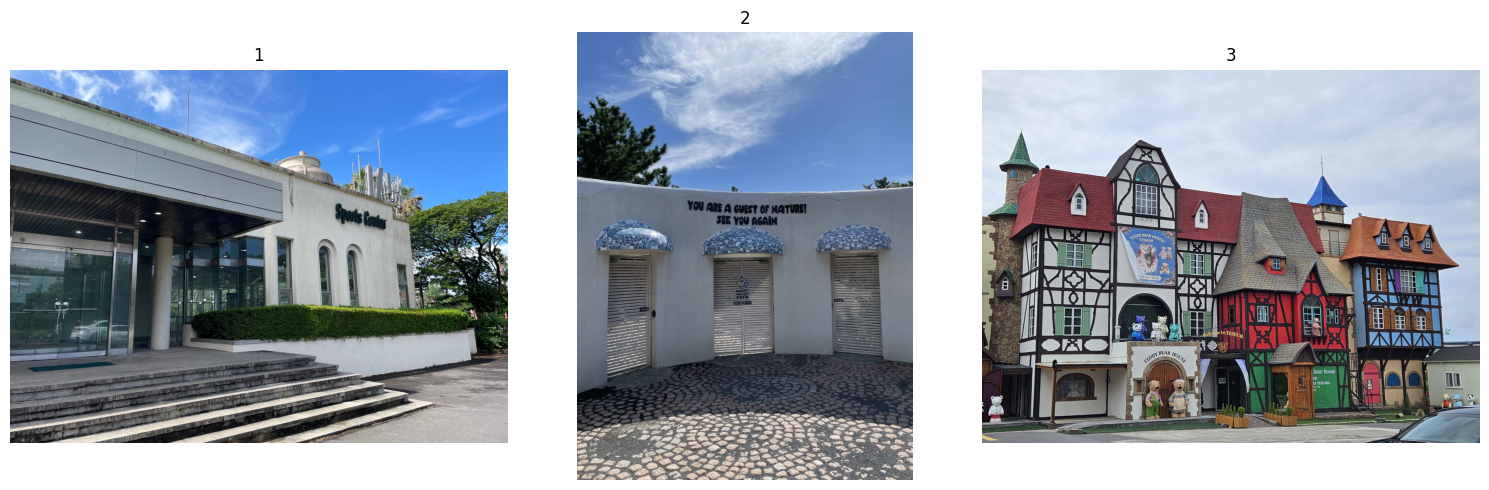

response_1의 이미지 중 가장 마음에 드는 번호를 입력하세요 (1-3): 2


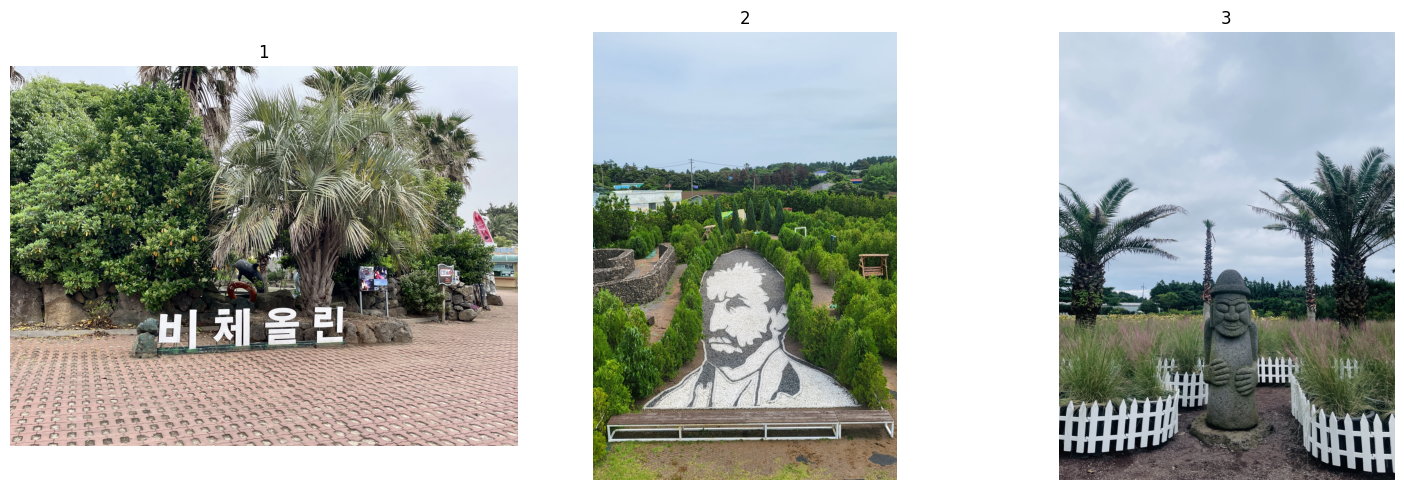

response_2의 이미지 중 가장 마음에 드는 번호를 입력하세요 (1-3): 1


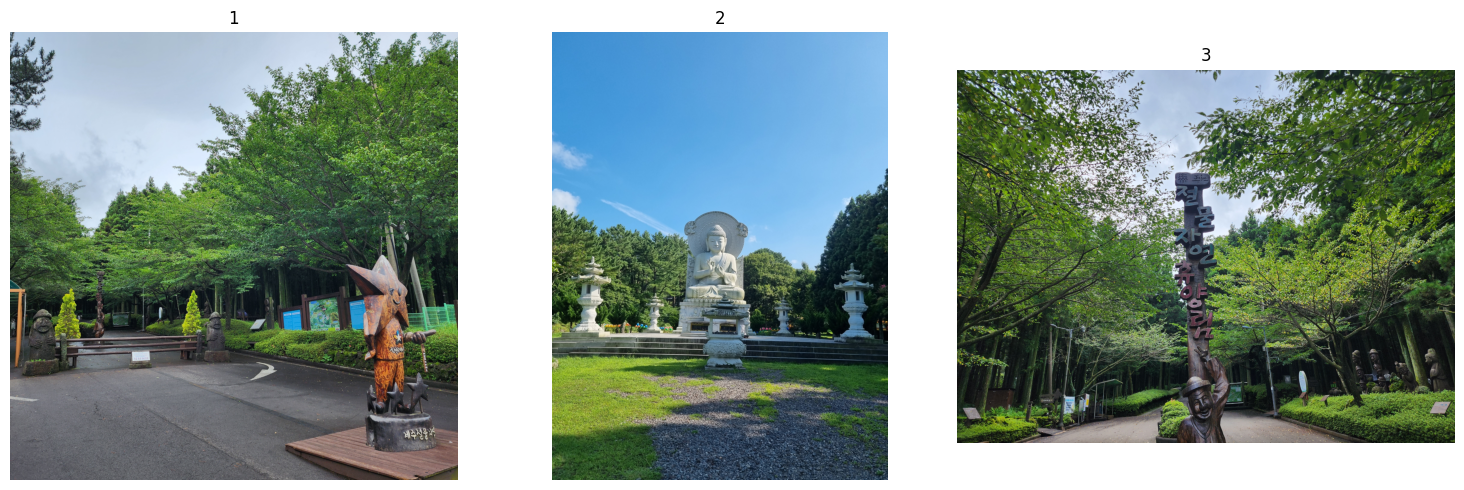

response_3의 이미지 중 가장 마음에 드는 번호를 입력하세요 (1-3): 1


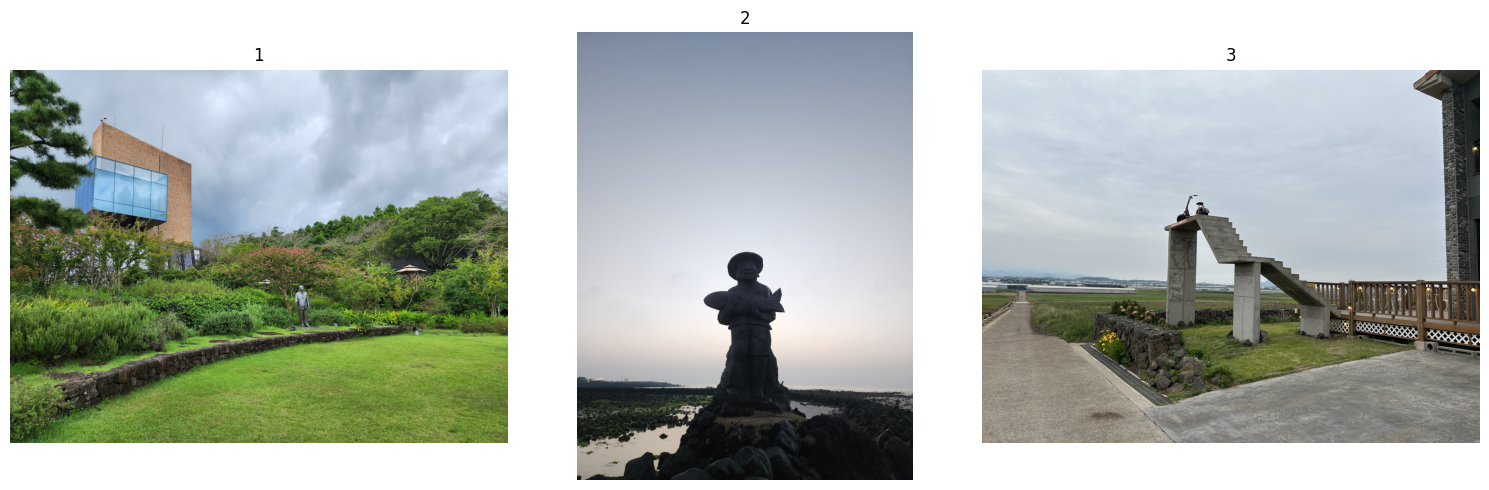

response_4의 이미지 중 가장 마음에 드는 번호를 입력하세요 (1-3): 3
선택된 이미지: {'response_1': 'h00494703008p0003.jpg', 'response_2': 'h00018502002p0001.jpg', 'response_3': 'h00102503002p0001.jpg', 'response_4': 'h00086102002p0007.jpg'}


In [ ]:
# 딕셔너리로 저장
similar_images = {}

for category in categories :
    similar_images[category] = final_similarity_df_test[final_similarity_df_test['response_column'] == category].nlargest(3, 'cosine_similarity')
    similar_images[category] = similar_images[category].reset_index(drop=True)


image_directory = '/content/drive/MyDrive/filtered_images3'

# 사용자로부터 선호하는 이미지를 여러 개 보여주고 선택하도록 함
def display_images_and_select(response_name, image_filenames):
    selected_image = None
    image_paths = []

    # 모든 이미지를 한 번에 표시
    plt.figure(figsize=(15, 5))  # 이미지를 잘 보기 위해 크기를 조절
    for i, row in image_filenames.iterrows():
        filename = row['aihub_image']
        image_path = os.path.join(image_directory, filename)
        image_paths.append(image_path)

        # 이미지가 존재하면 표시
        if os.path.exists(image_path):
            plt.subplot(1, len(image_filenames), i + 1)  # 여러 이미지를 한 줄에 표시
            img = Image.open(image_path)
            img = ImageOps.exif_transpose(img)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{i + 1}")
        else:
            print(f"이미지 {filename}을(를) {image_path}에서 찾을 수 없습니다.")
            return None  # 이미지가 없으면 종료

    # 모든 이미지를 표시하고 일정 시간 기다림
    plt.tight_layout()
    plt.show()  # 이미지를 보여줌
    plt.pause(1)  # 잠시 기다려서 이미지가 화면에 완전히 그려지도록 함

    # 사용자에게 입력을 요청
    user_input = input(f"{response_name}의 이미지 중 가장 마음에 드는 번호를 입력하세요 (1-{len(image_filenames)}): ")

    # 사용자 입력을 바탕으로 선택된 이미지 반환
    if user_input.isdigit():
        index = int(user_input) - 1
        if 0 <= index < len(image_paths):
            selected_image = image_filenames.iloc[index]['aihub_image']
        else:
            print("잘못된 입력입니다. 유효한 번호를 입력하세요.")
    else:
        print("숫자를 입력하세요.")

    return selected_image

selected_images = {}
for response_name, df in similar_images.items():
    selected_image = display_images_and_select(response_name, df)
    if selected_image:
        selected_images[response_name] = selected_image

# 선택된 이미지 출력
print("선택된 이미지:", selected_images)

## Step 2(유저 선호도 기반)

가장 높은 평균 유사도를 가진 이미지: h00086102002p0007.jpg


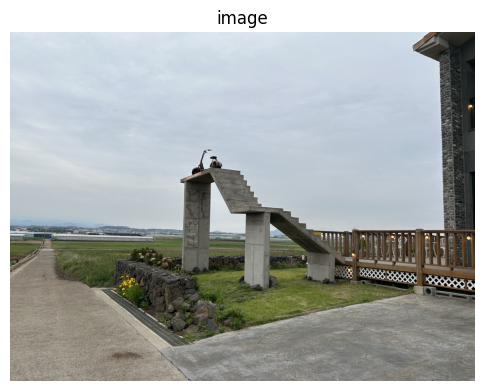

In [ ]:
similarity_info = []

# 선택된 이미지의 각 response에 대한 유사도 정보 저장
for response, selected_image in selected_images.items():
    # 선택된 이미지와 response가 일치하는 경우에 대해서만 유사도 정보를 가져오기
    selected_similarities = final_similarity_df.loc[
        ((final_similarity_df['image_1'] == selected_image) | (final_similarity_df['image_2'] == selected_image)) &
        (final_similarity_df['response_column'] == response)
    ]

    for _, row in selected_similarities.iterrows():
        other_image = row['image_2'] if row['image_1'] == selected_image else row['image_1']
        similarity_info.append({
            'response': response,
            'selected_image': selected_image,
            'other_image': other_image,
            'cosine_similarity': row['cosine_similarity']
        })

# 자기 자신과의 유사도 추가
for response, df in similar_images.items():
    for selected_image in selected_images.values():
        # 해당 response에 선택된 이미지가 포함되는 경우에만 자기 자신과의 유사도 추가
        if selected_image in df['aihub_image'].values:
            similarity_info.append({
                'response': response,
                'selected_image': selected_image,
                'other_image': selected_image,
                'cosine_similarity': 1.0  # 자기 자신과의 유사도는 1로 가정
            })

# 각 other_image에 대해 cosine similarity 값을 모아 평균 계산
average_similarities = {}

# similarity_info에서 other_image별로 cosine similarity 모음
for info in similarity_info:
    other_image = info['other_image']
    if other_image not in average_similarities:
        average_similarities[other_image] = []
    average_similarities[other_image].append(info['cosine_similarity'])

# 각 other_image의 평균 유사도 계산
for image, similarities in average_similarities.items():
    average_similarities[image] = sum(similarities) / len(similarities)

# 가장 높은 평균 유사도를 가진 이미지 찾기
if average_similarities:
    most_similar_image = max(average_similarities, key=average_similarities.get)
    print(f"가장 높은 평균 유사도를 가진 이미지: {most_similar_image}")
    most_similar_image_path = os.path.join(image_directory, most_similar_image)
    if os.path.exists(most_similar_image_path):
        plt.figure(figsize=(6, 6))
        img = Image.open(most_similar_image_path)
        img = ImageOps.exif_transpose(img)
        plt.imshow(img)
        plt.axis('off')
        plt.title("image")
        plt.show()
else:
    print("유사도 정보를 찾을 수 없습니다.")

# 4. Recommendation - 2 (user and review data)

In [ ]:
# 추천된 사진에 대응하는 recommend_table 행(장소) 추출
spot = recommend_table.loc[recommend_table['PHOTO_FILE_NM']==most_similar_image]
spot

VISIT_AREA_ID  TRAVEL_ID TRAVELER_ID VISIT_AREA_NM  \
1390     2306180001  h_h000861     h000861       노을해안114   

                    ROAD_NM_ADDR             POI_ID    POI_NM     X_COORD  \
1390  제주특별자치도 제주시 한경면 노을해안로 1014  POI01000000CSWNVE  노을해안1014  126.168558   

        Y_COORD   ratings          PHOTO_FILE_NM           combined_id  \
1390  33.297686  4.666667  h00086102002p0007.jpg  h_h000861_2306180001   

      GENDER  AGE_GRP  TRAVEL_STYL_1  TRAVEL_MOTIVE_1  
1390       1       20              4                2

## 사용자 정보 및 리뷰 기반 동선 추천 알고리즘

In [ ]:
# 사용자 정보 입력
def get_traveler_input():
    gender = int(input("성별을 입력하세요 (남=0, 여=1): "))
    age_group = int(input("나이대 (예: 20대=20, 30대=30)를 입력하세요: "))
    travel_style = int(input("여행 스타일을 입력하세요 (1~7 사이 숫자): "))
    travel_motive = int(input("여행 동기를 입력하세요 (1~10 사이 숫자): "))

    # 입력값을 new_traveler 배열로 반환
    new_traveler = np.array([gender, age_group, travel_style, travel_motive])
    return new_traveler

### 동선 후보군 추천

In [ ]:
# 사용자 유사도 계산
def similarity(new_traveler, recommend_table_near):
    # 명목형 변수 유사도 계산: 같으면 0.5, 다르면 0 (단순 일치 계수)
    nominal_similarity = (recommend_table_near[['GENDER', 'TRAVEL_MOTIVE_1']] == new_traveler[[0, 3]]).astype(int)

    # 순서형 변수 유사도 계산: 값 차이에 따라 유사도 적용 (Hamming Distance 사용)
    age_diff = np.abs(recommend_table_near['AGE_GRP'] - new_traveler[1])
    travel_style_diff = np.abs(recommend_table_near['TRAVEL_STYL_1'] - new_traveler[2])

    ordinal_similarity = pd.DataFrame({
        'AGE_SIM': 1 - (age_diff / age_diff.max()),  # 정규화
        'STYLE_SIM': 1 - (travel_style_diff / travel_style_diff.max())  # 정규화
    })

    # 전체 유사도: 명목형과 순서형 유사도의 평균
    similarity = (nominal_similarity.mean(axis=1) + ordinal_similarity.mean(axis=1)) / 2

    return similarity

# 동선 후보군 추천 함수
def recommend(spot, new_traveler, metric = 'knn', K=51, R=0.1):
    # 위도, 경도 좌표 데이터
    spot_coord = spot[['X_COORD','Y_COORD']].values
    coords = spot_table[['X_COORD','Y_COORD']]

    # 가까운 거리 내에 있는 장소로 필터링
    if metric == 'knn':
        knn = NearestNeighbors(n_neighbors=K)
        knn.fit(coords)

        spot_coord = spot_coord.reshape(1,-1)
        dist, idx = knn.kneighbors(spot_coord)
        idx = idx.reshape(-1)

        near_place = spot_table.loc[idx]
        near_place['Distance'] = dist.reshape(-1)
    else:
        spot_coord = spot_coord.reshape(-1)
        x = spot_coord[0]
        y = spot_coord[1]

        near_place = spot_table.copy()
        near_place['Distance'] = np.sqrt((near_place['X_COORD'] - x)**2 + (near_place['Y_COORD'] - y)**2)
        near_place = near_place[near_place.Distance<R]

    near_POI = near_place['POI_ID']
    recommend_table_near = spot_table[spot_table.POI_ID.isin(near_POI)].reset_index(drop = True)

    # 사용자 유사도 측정
    similar_travelers = recommend_table_near.copy()
    similar_travelers['SIMILARITY'] = similarity(new_traveler, recommend_table_near)

    # 가장 유사한 사용자 데이터만 불러오기
    max_idx = similar_travelers.groupby('POI_ID')['SIMILARITY'].idxmax()
    result = similar_travelers.loc[max_idx]

    # 사용자 만족도 4이상인 곳만 필터링
    result = result[result.ratings >= 4]

    # 리뷰 기반 score 측정
    embeddings = result.iloc[:,-769:-1].values
    whole_weight = result['SIMILARITY'].values.sum()

    # 유사도를 가중치로 하는 리뷰 벡터의 가중 평균 벡터
    centroid = result['SIMILARITY'].values.reshape(-1,1) * embeddings/whole_weight

    # 가중합 벡터와 가까울수록 높은 스코어 책정
    score = np.sum((embeddings-centroid)**2,axis=1)
    eps = 1e-3
    result['Score'] = 1/(score+eps)

    # 사용자에게서 추천될 장소의 수 입력 받기
    n=int(input("추천할 장소의 수를 입력하세요: "))
    result = result.sort_values(by='Score', ascending=False).iloc[:n]
    return result

# 사용자 입력을 통해 new_traveler 생성
new_traveler = get_traveler_input()
locations = recommend(spot,new_traveler,metric = 'knn')

성별을 입력하세요 (남=0, 여=1): 1
나이대 (예: 20대=20, 30대=30)를 입력하세요: 20
여행 스타일을 입력하세요 (1~10 사이 숫자): 1
여행 동기를 입력하세요 (1: 육체 피로 해결, 2: 정신적인 휴식, 3: 자신 되돌아보기 등): 1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


추천할 장소의 수를 입력하세요: 7


### 데이터 기반 장소 정보 제공(평균 방문 시간, 주변 식당)

In [ ]:
# 데이터 기반, 장소 평균 방문 시간 매칭 함수
def locations_with_time(locations, act_consume):
    # 새로운 컬럼 생성
    locations['avg_payment_time'] = None

    for idx, row in locations.iterrows():
        road_nm_addr = row['ROAD_NM_ADDR']

        # act_consume 데이터프레임에서 해당 ROAD_NM_ADDR를 가지는 행 필터링
        matching_rows = act_consume[act_consume['ROAD_NM_ADDR'] == road_nm_addr]

        if not matching_rows.empty:
            # PAYMENT_DT에서 시간 부분 (HH:MM)만 추출하여 datetime 형식으로 변환
            matching_rows['PAYMENT_TIME'] = pd.to_datetime(matching_rows['PAYMENT_DT'], errors='coerce').dt.strftime('%H:%M')

            # 유효한 시간 값만 선택 (NaN 값 제외)
            valid_times = matching_rows['PAYMENT_TIME'].dropna()
            if not valid_times.empty:
                # 시간 부분을 'HH:MM' 포맷의 문자열로 유지하여 hour와 minute을 분리 후 초로 변환
                valid_times_minutes = valid_times.apply(lambda t: int(t[:2]) * 60 + int(t[3:]))
                avg_minutes = valid_times_minutes.mean()

                # 평균 분을 'HH:MM' 형식으로 변환
                avg_hours = int(avg_minutes // 60)
                avg_minutes = int(avg_minutes % 60)

                # 평균 시간을 'HH:MM' 형식으로 저장
                avg_payment_time = f"{avg_hours:02}:{avg_minutes:02}"
                locations.at[idx, 'avg_payment_time'] = avg_payment_time
            else:
                # 유효한 시간이 없을 경우 None 할당
                locations.at[idx, 'avg_payment_time'] = None

    return locations

In [ ]:
# 주변 식당 및 카페 추천 기능
def extract_dining(locations, act_consume):
    # 각 장소별 결과를 저장할 리스트
    location_results = []

    # locations의 각 행에 대해 반복
    for _, location_row in locations.iterrows():
        target_travel_id = location_row['TRAVEL_ID']
        target_road_nm_addr = location_row['ROAD_NM_ADDR']
        poi_name = location_row['POI_NM']

        # act_consume에서 해당 TRAVEL_ID를 가지는 모든 데이터 가져오기
        filtered_df = act_consume[act_consume['TRAVEL_ID'] == target_travel_id]

        # PAYMENT_DT 순으로 정렬
        sorted_df = filtered_df.sort_values(by='PAYMENT_DT').reset_index(drop=True)

        # 기준이 되는 행 찾기 (ROAD_NM_ADDR가 동일한 첫 번째 행)
        reference_row = sorted_df[sorted_df['ROAD_NM_ADDR'] == target_road_nm_addr].head(1)

        if reference_row.empty:
            # 기준 행이 없는 경우 빈 데이터프레임을 결과 리스트에 추가하고 다음으로 넘어감
            location_results.append((poi_name, pd.DataFrame()))
            continue

        # 기준 행의 인덱스 가져오기
        ref_index = reference_row.index[0]

        # 전후로 ACTIVITY_TYPE_CD 값이 1인 데이터를 찾기
        activity_data = []

        # 이전 행에서 최대 2개의 행 찾기
        count = 0
        for i in range(ref_index - 1, -1, -1):
            if sorted_df.loc[i, 'ACTIVITY_TYPE_CD'] == 1:
                activity_data.append(sorted_df.loc[i])
                count += 1
                if count == 2:
                    break

        # 이후 행에서 최대 2개의 행 찾기
        count = 0
        for i in range(ref_index + 1, len(sorted_df)):
            if sorted_df.loc[i, 'ACTIVITY_TYPE_CD'] == 1:
                activity_data.append(sorted_df.loc[i])
                count += 1
                if count == 2:
                    break

        # 추출한 데이터를 하나의 데이터프레임으로 변환하여 리스트에 (POI_NM, 데이터프레임) 형태로 저장
        result_df = pd.DataFrame(activity_data)
        location_results.append((poi_name, result_df))

    return location_results

In [ ]:
# n을 입력받도록 하고, 장소 선택하는 코드 추가해야함
locations_time = locations_with_time(locations, act_consume)
locations_time=locations_time.reset_index(drop=True)

<ipython-input-32-eeb0bcdc14ad>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matching_rows['PAYMENT_TIME'] = pd.to_datetime(matching_rows['PAYMENT_DT'], errors='coerce').dt.strftime('%H:%M')
<ipython-input-32-eeb0bcdc14ad>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matching_rows['PAYMENT_TIME'] = pd.to_datetime(matching_rows['PAYMENT_DT'], errors='coerce').dt.strftime('%H:%M')
<ipython-input-32-eeb0bcdc14ad>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [ ]:
def filter_places(locations_df):

    # 1부터 시작하는 인덱스를 보여줌
    print("코스를 생성할 여행지를 선택")
    display_df = locations_df[['VISIT_AREA_NM']].copy()  # 장소 이름만 표시할 임시 데이터프레임 생성
    display_df.index += 1  # 인덱스를 1부터 시작하도록 조정
    print(display_df)  # 인덱스가 1부터 시작하는 형태로 출력

    # 사용자가 원하는 인덱스 번호 입력
    selected_indexes = input("원하는 장소에 해당하는 번호를 쉼표로 구분하여 입력하세요: ").split(',')
    # 입력된 인덱스를 정수로 변환하고, 불필요한 공백 제거 후 1을 빼서 원래 인덱스로 변환
    selected_indexes = [int(index.strip()) - 1 for index in selected_indexes]
    1
    # 메인 장소(첫번째 행) 은 항상 포함되도록 설정
    if 0 not in selected_indexes:
        selected_indexes.insert(0, 0)

    # 선택한 인덱스를 기반으로 데이터프레임 필터링
    sub_df = locations_df.loc[selected_indexes]

    # 필터링된 서브 데이터프레임을 표시하거나 저장할 수 있도록 반환
    return sub_df

# 사용 예시
filtered_locations = filter_places(locations_time)
print(filtered_locations)

코스를 생성할 여행지를 선택
       VISIT_AREA_NM
1  성 김대건 신부 제주 표착기념관
2            제주현대미술관
3   반디 파스타 저지 오름 직영점
4                방림원
5        곶자왈 반딧불이 축제
6            메리 아일랜드
7             수용 배낚시
원하는 장소에 해당하는 번호를 쉼표로 구분하여 입력하세요: 1, 2, 4, 5, 6
   VISIT_AREA_ID  TRAVEL_ID TRAVELER_ID      VISIT_AREA_NM  \
0     2306030006  h_h000336     h000336  성 김대건 신부 제주 표착기념관   
1     2306130007  h_h000724     h000724            제주현대미술관   
3     2306240008  h_h001034     h001034                방림원   
4     2306130007  h_h000781     h000781        곶자왈 반딧불이 축제   
5     2308240001  h_h005028     h005028            메리 아일랜드   

               ROAD_NM_ADDR             POI_ID          POI_NM     X_COORD  \
0  제주특별자치도 제주시 한경면 용수1길 108  POI01000TR012997V  성김대건신부 제주표착기념관  126.167705   
1  제주특별자치도 제주시 한경면 저지14길 35  POI010000006VTCAC         제주현대미술관  126.265585   
3   제주특별자치도 제주시 한경면 용금로 864  POI01000000CIY23T             방림원  126.268528   
4   제주특별자치도 제주시 한경면 연명로 348  POI02000TR000774V       곶자왈반딧불이축제  126.259040   
5    제

In [ ]:
dining = extract_dining(filtered_locations, act_consume)

In [ ]:
def convert_dining_to_multiindex(dining):
    # 각 POI_NM별로 데이터를 처리하여 하나의 DataFrame으로 변환
    data = []
    for poi_name, dining_df in dining:
        dining_df['POI_NM'] = poi_name  # 각 DataFrame에 POI_NM 컬럼 추가
        data.append(dining_df)

    # 모든 데이터를 하나로 합침
    combined_df = pd.concat(data, ignore_index=True)

    # MultiIndex 생성
    combined_df.set_index(['POI_NM', combined_df.groupby('POI_NM').cumcount() + 1], inplace=True)

    return combined_df

# dining을 MultiIndex DataFrame으로 변환
dining_multiindex_df = convert_dining_to_multiindex(dining)
dining_multiindex_df

TRAVEL_ID  VISIT_AREA_ID  ACTIVITY_TYPE_CD  ACTIVITY_TYPE_SEQ  \
POI_NM                                                                       
제주현대미술관   1  h_h000724   2.306130e+09               1.0                0.0   
          2  h_h000724   2.306130e+09               1.0                1.0   
          3  h_h000724   2.306130e+09               1.0                0.0   
          4  h_h000724   2.306140e+09               1.0                2.0   
방림원       1  h_h001034   2.306240e+09               1.0                0.0   
          2  h_h001034   2.306240e+09               1.0                0.0   
          3  h_h001034   2.306250e+09               1.0                0.0   
          4  h_h001034   2.306250e+09               1.0                0.0   
곶자왈반딧불이축제 1  h_h000781   2.306130e+09               1.0                0.0   
          2  h_h000781   2.306120e+09               1.0                0.0   
          3  h_h000781   2.306140e+09               1.0                0.0   
          4  h_h000781   2.306140e+09               1.0                0.0   

             CONSUME_HIS_SEQ  CONSUME_HIS_SNO  PAYMENT_NUM          BRNO  \
POI_NM                                                                     
제주현대미술관   1              0.0              1.0          1.0  3.885801e+09   
          2              1.0              1.0          1.0  1.043424e+09   
          3              0.0              1.0          1.0  6.162675e+09   
          4              2.0              1.0          1.0  6.162987e+09   
방림원       1              0.0              1.0          4.0  1.761902e+09   
          2              0.0              1.0          4.0  3.650801e+09   
          3              0.0              1.0          4.0  6.098702e+09   
          4              0.0              1.0          4.0  2.111764e+09   
곶자왈반딧불이축제 1              0.0              1.0          4.0  4.226000e+09   
          2              0.0              1.0          4.0  2.508103e+09   
          3              0.0              1.0          4.0  6.890203e+09   
          4              0.0              1.0          4.0  8.226101e+09   

               STORE_NM                ROAD_NM_ADDR  \
POI_NM                                                
제주현대미술관   1     서담갤러리카페   제주특별자치도 제주시 한경면 저지12길 102   
          2        자매식당       제주특별자치도 제주시 한경면 고산로 4   
          3         홍성방   제주특별자치도 서귀포시 대정읍 하모항구로 76   
          4    수두리보말칼국수       제주특별자치도 서귀포시 천제연로 192   
방림원       1        카페올린   제주특별자치도 제주시 한경면 판조로 253-6   
          2         제갈양     제주특별자치도 제주시 한림읍 한림로 155   
          3  (주)유동커피팩토리     제주특별자치도 서귀포시 솜반천로6번길 11   
          4         돈꿀꺽    제주특별자치도 제주시 애월읍 평화로 2187   
곶자왈반딧불이축제 1     심야식당유카이  제주특별자치도 서귀포시 대정읍 보성구억로 220   
          2     팔미돈가흑돼지   제주특별자치도 서귀포시 성산읍 서성일로 511   
          3       금능둘레길      제주특별자치도 제주시 한림읍 금능길 79   
          4        카페신상       제주특별자치도 제주시 테우해안로 144   

                              LOTNO_ADDR  ROAD_NM_CD      LOTNO_CD  \
POI_NM                                                               
제주현대미술관   1  제주특별자치도 제주시 한경면 저지리 2120-17   4848635.0  5.011031e+09   
          2   제주특별자치도 제주시 한경면 고산리 2863-6   3349008.0  5.011031e+09   
          3   제주특별자치도 서귀포시 대정읍 하모리 938-4   3350299.0  5.013025e+09   
          4      제주특별자치도 서귀포시 중문동 2056-2   3350258.0  5.013011e+09   
방림원       1    제주특별자치도 제주시 한경면 판포리 725-1   3349200.0  5.011031e+09   
          2     제주특별자치도 제주시 한림읍 금능리 1737   3349208.0  5.011025e+09   
          3      제주특별자치도 서귀포시 서홍동 397-50   4850498.0  5.013011e+09   
          4  제주특별자치도 제주시 애월읍 소길리 155-121   3349240.0  5.011025e+09   
곶자왈반딧불이축제 1                          NaN   3350100.0  5.013025e+09   
          2  제주특별자치도 서귀포시 성산읍 난산리 2625-4   3350145.0  5.013026e+09   
          3     제주특별자치도 제주시 한림읍 금능리 1420   4847286.0  5.011025e+09   
          4      제주특별자치도 제주시 이호일동 1788-1   3349243.0  5.011012e+09   

                   PAYMENT_DT  PAYMENT_MTHD_SE  PAYMENT_AMT_WON  \
POI_NM                              

In [ ]:
# POI_ID별로 'STORE_NM' 목록 추출
poi_store_mapping = dining_multiindex_df.groupby('POI_NM')['STORE_NM'].apply(list).reset_index()

# 결과 출력
print(poi_store_mapping)

      POI_NM                         STORE_NM
0  곶자왈반딧불이축제  [심야식당유카이, 팔미돈가흑돼지, 금능둘레길, 카페신상]
1        방림원     [카페올린, 제갈양, (주)유동커피팩토리, 돈꿀꺽]
2    제주현대미술관   [서담갤러리카페, 자매식당, 홍성방, 수두리보말칼국수]


## 워드 클라우드 생성
워드 클라우드를 생성하여, 새로운 사용자의 성향을 키워드로 한눈에 확인

In [ ]:
# 전처리 함수
def safe_literal_eval(text):
    # 문장부호를 제외한 특수문자 제거
    text = re.sub(r'[^a-zA-Z0-9ㄱ-ㅎㅏ-ㅣ가-힣\s.,!?;:\'"]', '', text)
    # ㅋㅋ나 ㅠㅠ와 같은 자음이나 모음만으로 구성된 불완전한 텍스트 제거
    text = re.sub(r'(ㅋ+|ㅠ+|ㅜ+|^ㄱ|ㄴ|ㅇ|ㅁ|ㅂ|ㅈ|ㅊ|ㅌ|ㅍ|ㅎ|ㅏ|ㅑ|ㅓ|ㅕ|ㅗ|ㅛ|ㅜ|ㅠ|ㅡ|ㅣ)', '', text)
    try:
        # 역슬래시 제거 후 str -> list
        return ast.literal_eval(text.replace("\\'", "'"))
    except (SyntaxError, ValueError):
        return []

# 워드 클라우드 생성 함수
def word_cloud(locations):
    plt.rc('font', family='NanumGothic')

    # 한국어 불용어 로드
    path = "/content/drive/MyDrive/148.국내 여행로그 데이터_제주도 및 도서지역_2차년도/3.개방데이터/1.데이터/Training/TL_CSV/stopwords.txt"
    with open(path, 'r', encoding='utf-8') as f:
        stopwords = f.read().splitlines()

    okt = Okt()
    words = []

    # 추천지의 모든 리뷰에 대해 전처리/ 불용어 제거/ 명사, 동사, 형용사 추출
    for i,row in locations['comment_text'].items():
        reviews = safe_literal_eval(row)
        for review in reviews:
            words += [word for word, pos in okt.pos(review)
            if (pos in ['Noun', 'Verb', 'Adjective']) &(word not in stopwords)]

    # 단어 리스트를 하나의 문자열로 결합
    text = ' '.join(words)

    # 워드 클라우드 생성
    wordcloud = WordCloud(
        font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
        width=800,
        height=400,
        background_color='white'
    ).generate(text)

    # 워드 클라우드 출력
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

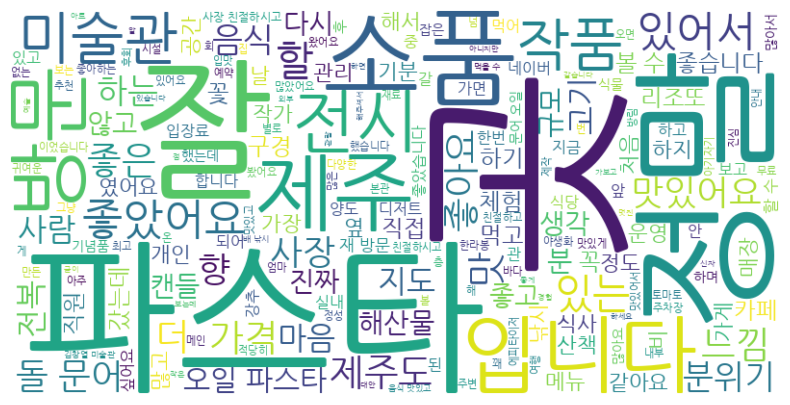

In [ ]:
word_cloud(locations_time)

## 동선 최적화

In [ ]:
# Naver API 설정
NAVER_CLIENT_ID = "lufec25vd7"
NAVER_CLIENT_SECRET = input("Naver-Client-Secret:")
headers = {
    "X-NCP-APIGW-API-KEY-ID": NAVER_CLIENT_ID,
    "X-NCP-APIGW-API-KEY": NAVER_CLIENT_SECRET
}

def path_optimizer(spot, locations):
    # 중복된 좌표 제거 및 초기화
    locations = locations.drop_duplicates(subset=['X_COORD', 'Y_COORD'], keep='first')
    locations = locations[~locations['VISIT_AREA_NM'].isin(spot['VISIT_AREA_NM'])].reset_index(drop=True)

    spot_coord = spot[['X_COORD', 'Y_COORD']]
    coordinates = pd.concat([spot_coord, locations[['X_COORD', 'Y_COORD']]], axis=0, ignore_index=True).values
    num_locations = len(coordinates)
    distance_matrix = np.zeros((num_locations, num_locations))
    duration_matrix = np.zeros((num_locations, num_locations))

    # 거리 및 소요 시간 계산
    for i in range(num_locations):
        for j in range(num_locations):
            if i != j:
                start = f"{coordinates[i][0]},{coordinates[i][1]}"
                end = f"{coordinates[j][0]},{coordinates[j][1]}"
                url = f"https://naveropenapi.apigw.ntruss.com/map-direction/v1/driving?start={start}&goal={end}&option=trafast"
                response = requests.get(url, headers=headers)
                if response.status_code == 200:
                    result = response.json()
                    if result['route']:
                        distance = result['route']['trafast'][0]['summary']['distance']
                        duration = result['route']['trafast'][0]['summary']['duration']
                        distance_matrix[i][j] = distance
                        duration_matrix[i][j] = duration
                    else:
                        print(f"경로 없음: {i} -> {j}")
                else:
                    print(f"API 요청 실패: {response.status_code}")

    # 최적 경로 찾기
    min_path, min_duration, total_distance = None, float('inf'), 0
    for perm in itertools.permutations(range(1, num_locations)):
        current_path = [0] + list(perm)
        current_duration, current_distance = 0, 0
        for k in range(len(current_path) - 1):
            current_duration += duration_matrix[current_path[k]][current_path[k + 1]]
            current_distance += distance_matrix[current_path[k]][current_path[k + 1]]

        if current_duration < min_duration:
            min_duration = current_duration
            total_distance = current_distance
            min_path = current_path

    spot_df = pd.DataFrame(spot)
    ind = min_path[1:]
    ind = [x-1 for x in ind]
    result = pd.concat([spot_df, locations.loc[ind]]).reset_index(drop=True)

    print(f"총 이동 소요 시간: {int(min_duration / 60000)}분")
    print(f"총 거리: {total_distance}미터")
    print("여정 순서 및 정보")
    print("------------------------------------")
    result2=result[['POI_NM', 'ratings', 'SIMILARITY']]
    display(result2)

    # 각 POI 간의 소요 시간을 포함한 데이터프레임 생성 (도착지 기준)
    travel_times = []
    for i in range(len(min_path) - 1):
        start_index = min_path[i]
        end_index = min_path[i + 1]
        travel_time = round(duration_matrix[start_index, end_index] / 60000)  # ms -> min

        # 출발지와 도착지를 올바르게 설정
        start_location = locations.iloc[start_index - 1]['VISIT_AREA_NM'] if start_index > 0 else spot.iloc[0]['VISIT_AREA_NM']
        end_location = locations.iloc[end_index - 1]['VISIT_AREA_NM'] if end_index > 0 else spot.iloc[0]['VISIT_AREA_NM']

        travel_times.append({
            '출발': start_location,
            '도착': end_location,
            '소요시간': travel_time
        })

    # 새로운 데이터프레임 생성
    travel_df = pd.DataFrame(travel_times)
    display(travel_df)

    # `duration_matrix`와 `distance_matrix` 추가 반환
    return result, min_duration, total_distance, duration_matrix, distance_matrix

# path_optimizer 호출 예제


filtered_locations[['POI_NM', 'ratings', 'SIMILARITY']].reset_index(drop=True)
path, duration, dist, duration_matrix, _ = path_optimizer(spot, filtered_locations)


Naver-Client-Secret:9tc3oII8TjHJgrdX9sgdgIEt8ieNeRuaacQG2ADB
총 이동 소요 시간: 47분
총 거리: 30328.0미터
여정 순서 및 정보
------------------------------------


POI_NM   ratings  SIMILARITY
0        노을해안1014  4.666667         NaN
1  성김대건신부 제주표착기념관  5.000000    0.562500
2       곶자왈반딧불이축제  4.000000    0.625000
3             방림원  5.000000    0.666667
4         제주현대미술관  5.000000    0.562500
5          메리아일랜드  5.000000    0.750000

출발                 도착  소요시간
0            노을해안114  성 김대건 신부 제주 표착기념관     7
1  성 김대건 신부 제주 표착기념관        곶자왈 반딧불이 축제    18
2        곶자왈 반딧불이 축제                방림원    10
3                방림원            제주현대미술관     1
4            제주현대미술관            메리 아일랜드    11

# 5. Visualization with Map API

In [ ]:
# 네이버 API 키 설정
headers = {
    "X-Naver-Client-Id": "pbn5UWRRNtptJlgjHgyy",
    "X-Naver-Client-Secret": input("Naver-Client-Secret:")
}


# 카카오 API 키 설정
kakao_headers = {
    "Authorization": input('kakao API KEY:')
}


def get_route(origin, destination):
    url = f"https://apis-navi.kakaomobility.com/v1/directions?origin={origin}&destination={destination}&priority=RECOMMEND"
    try:
        response = requests.get(url, headers=kakao_headers)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"경로 API 요청 실패: {e}")
        return None

def search_image(visit_area_nm, max_retries=10):
    encoded_query = urllib.parse.quote(visit_area_nm)
    url = f"https://openapi.naver.com/v1/search/image.json?query={encoded_query}&display=1&start=1&sort=sim"
    for attempt in range(max_retries):
        try:
            response = requests.get(url, headers=headers)
            response.raise_for_status()
            result = response.json()
            if 'items' in result and result['items']:
                return result['items'][0]['link']
            else:
                return None
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                time.sleep(2)
            else:
                return None

def visualize_path_on_map(route_data, route_map, color):
    if route_data and 'routes' in route_data and len(route_data['routes']) > 0:
        route_coords = route_data['routes'][0]['sections'][0]['roads']
        all_vertexes = []
        for road in route_coords:
            vertexes = road['vertexes']
            for i in range(0, len(vertexes), 2):
                all_vertexes.append([vertexes[i + 1], vertexes[i]])
        folium.PolyLine(locations=all_vertexes, color=color, weight=5, opacity=0.7).add_to(route_map)

def create_map_with_markers_and_ordered_paths(path, poi_store_mapping):
    route_map = folium.Map(location=(path.iloc[0]['Y_COORD'], path.iloc[0]['X_COORD']), zoom_start=12)
    colormap = cm.get_cmap('rainbow', len(path) - 1)
    norm = colors.Normalize(vmin=0, vmax=len(path) - 2)

    for i in range(len(path) - 1):
        origin = f"{path.iloc[i]['X_COORD']},{path.iloc[i]['Y_COORD']}"
        destination = f"{path.iloc[i + 1]['X_COORD']},{path.iloc[i + 1]['Y_COORD']}"
        route_data = get_route(origin, destination)
        route_color = 'blue'

        if route_data:
            visualize_path_on_map(route_data, route_map, color=route_color)

        poi_name = path.iloc[i]['VISIT_AREA_NM'].strip().lower()
        image_url = search_image(poi_name)

        # 정규화된 POI 이름으로 매칭
        normalized_poi_name = poi_name.replace(" ", "").replace("-", "").replace("_", "")
        store_names = poi_store_mapping[
            poi_store_mapping['POI_NM'].str.replace(" ", "").str.replace("-", "").str.replace("_", "").str.lower() == normalized_poi_name
        ]['STORE_NM']

        store_names_list = store_names.iloc[0] if not store_names.empty else []
        stores_html = "<br>".join(store_names_list) if store_names_list else "No stores available"

        # 팝업 HTML 구성
        popup_html = f"<b>{i+1}. {poi_name}</b><br>"
        if image_url:
            popup_html += f"<img src='{image_url}' width='100'><br>"
        popup_html += f"식사 장소로 이곳은 어떤가요?:<br>{stores_html}"

        # 마커 추가, 팝업 최대 폭 증가
        folium.Marker(
            location=(path.iloc[i]['Y_COORD'], path.iloc[i]['X_COORD']),
            popup=folium.Popup(popup_html, max_width=500),
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(route_map)

    # 마지막 장소에 대한 마커 표시
    last_poi_name = path.iloc[-1]['VISIT_AREA_NM']
    last_image_url = search_image(last_poi_name)
    last_popup_html = f"<b>{len(path)}. {last_poi_name}</b><br>"
    if last_image_url:
        last_popup_html += f"<img src='{last_image_url}' width='100'><br>"

    folium.Marker(
        location=(path.iloc[-1]['Y_COORD'], path.iloc[-1]['X_COORD']),
        popup=folium.Popup(last_popup_html, max_width=300),
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(route_map)

    return route_map

# 예시 호출
route_map = create_map_with_markers_and_ordered_paths(path, poi_store_mapping)
route_map

Naver-Client-Secret:onAoSavYbe
kakao API KEY:KakaoAK fcf14da2e76244a746666e84a90b0900
